In [3]:
import librosa as lb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import librosa.display
from pydub import AudioSegment
import random
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import pickle

In [2]:
class SplitWavAudio():
    def __init__(self, folder, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '\\' + filename
        
        self.audio = AudioSegment.from_wav(self.filepath)
    
    def get_duration(self):
        return self.audio.duration_seconds
    
    def single_split(self, from_sec, to_sec, split_filename):
        t1 = from_sec * 1000
        t2 = to_sec * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\2-sec-snippets' + '\\' + split_filename, format="wav")
        
    def multiple_split(self, sec_per_split):
        total_secs = self.get_duration()
        for i in range(0, int(total_secs), sec_per_split):
            split_fn = str(i) + '_' + self.filename
            self.single_split(i, i+sec_per_split, split_fn)

In [3]:
# generate 2 second snippets audio files and save them into the other dir
data_dir = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\training-dataset'
filenames = os.listdir(data_dir)
for i in range(len(filenames)):
    split_wav = SplitWavAudio(data_dir, filenames[i])
    split_wav.multiple_split(sec_per_split=2)

In [2]:
snippets_data_dir = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\2-sec-snippets'
audio_files = glob(snippets_data_dir + '/*.wav')
snippets_filenames = os.listdir(snippets_data_dir)
file = random.randrange(len(audio_files))

In [4]:
# tempo
y, sr = lb.load(audio_files[file])
tempo, beat_frames = lb.beat.beat_track(y=y, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
beat_times = lb.frames_to_time(beat_frames, sr=sr)

Estimated tempo: 123.05 beats per minute


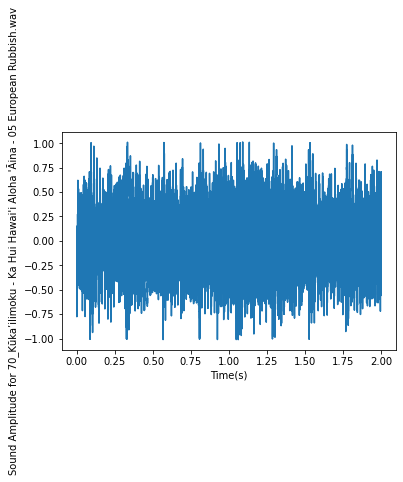

In [5]:
# sound amplitude graph
y, sr = lb.load(audio_files[file])
time = np.arange(0, len(y)) / sr
fig, ax = plt.subplots()
ax.plot(time, y)
ax.set(xlabel = 'Time(s)', ylabel = 'Sound Amplitude for ' + snippets_filenames[file])
plt.show()

c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\librosa\display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


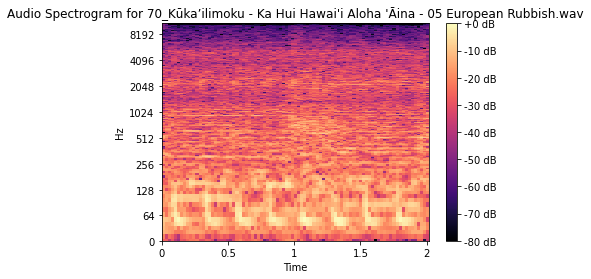

In [6]:
# spectrogram
y, sr = lb.load(audio_files[file])
S = np.abs(lb.stft(y))
S_random = S.copy()
fig, ax = plt.subplots()
S_dB_random = lb.amplitude_to_db(S_random, ref = np.max)
img = librosa.display.specshow(S_dB_random, x_axis='time', y_axis='log', ax=ax, sr=sr)
ax.set_title('Audio Spectrogram for ' + snippets_filenames[file])
fig.colorbar(img, ax=ax, format="%+2.0f dB")

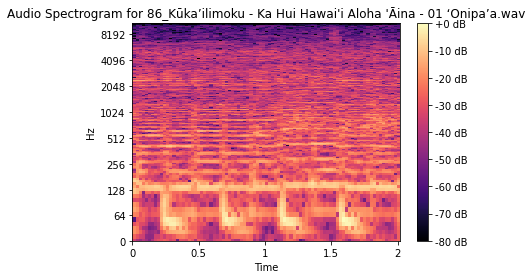

In [7]:
# spectrogram for heavy metal
y, sr = lb.load(audio_files[1535])
S = np.abs(lb.stft(y))
S_heavy_metal = S.copy()
fig, ax = plt.subplots()
S_dB_heavy_metal = lb.amplitude_to_db(S_heavy_metal, ref = np.max)
img = librosa.display.specshow(S_dB_heavy_metal, x_axis='time', y_axis='log', ax=ax, sr=sr)
ax.set_title('Audio Spectrogram for ' + snippets_filenames[1535])
fig.colorbar(img, ax=ax, format="%+2.0f dB")

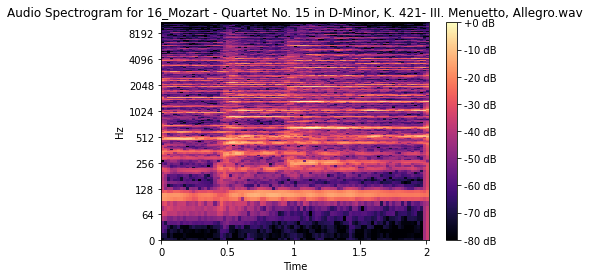

In [8]:
# spectrogram for classical ***
y, sr = lb.load(audio_files[456])
S = np.abs(lb.stft(y))
S_classical = S.copy()
fig, ax = plt.subplots()
S_dB_classical = lb.amplitude_to_db(S_classical, ref = np.max)
img = librosa.display.specshow(S_dB_classical, x_axis='time', y_axis='log', ax=ax, sr=sr)
ax.set_title('Audio Spectrogram for ' + snippets_filenames[456])
fig.colorbar(img, ax=ax, format="%+2.0f dB")

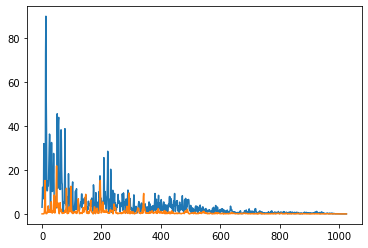

In [9]:
# plt.pcolormesh(S_heavy_metal**.3)
plt.plot(S_heavy_metal[:,40])
plt.plot(S_classical[:,40])

In [11]:
# prediction algorithm starts here (my algorithm :))

In [12]:
# function to guess what kind of music it is (2-sec)
def classify_genres(S_dB):
    in_range = 0;
    total = S_dB.shape[0]*S_dB.shape[1]
    for i in range(S_dB.shape[0]):
        for j in range(S_dB.shape[1]):
            if (S_dB[i][j] > -60):
                in_range = in_range +1
    print(in_range / total)
    if (in_range / total > 0.658):
        print("I guess it's heavy metal..")
    else:
        print("I guess it's classical..")

In [13]:
classify_genres(S_dB_random)

0.8644911690496215
I guess it's heavy metal..


In [14]:
# function to guess the genre from single column of random 2-sec spectrogram
def classify_genres_column(S_dB_column, classification):
    in_range = 0
    for i in range(S_dB_column.shape[0]):
        if (S_dB_column[i] > -60):
            in_range = in_range +1
    if (in_range / S_dB_column.shape[0] > 0.658):
        classification.append('heavy metal')
    else:
        classification.append('classical')
    return classification

In [15]:
times = 0
random_classification = []
while (times < S_dB_random.shape[1]):
    random_classification = classify_genres_column(S_dB_random[:,times], random_classification)
    times = times + 1
heavy_metal = 0
classical = 0
for i in range (len(random_classification)):
    if random_classification[i] == 'heavy metal':
        heavy_metal += 1
    elif random_classification[i] == 'classical':
        classical += 1
if heavy_metal >= classical:
    print("I guess it's heavy metal..")
else:
    print("I guess it's classical..")

I guess it's heavy metal..


In [85]:
#skLearn logistic regression starts here (entire song) - frame-by-frame classification

In [10]:
# training data provided
data_dir = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\training-dataset'
audio_files_whole_training = glob(data_dir + '/*.wav')

In [11]:
def get_training_dB_matrices(i):
    y, sr = lb.load(audio_files_whole_training[i])
    S = np.abs(lb.stft(y))
    return S

In [12]:
def get_corresponding_y_train(i):
    shape = np.shape(get_training_dB_matrices(i))[1]
    if i < 6:
        to_return = np.ones(shape)
        return to_return
    else: 
        to_return = np.zeros(shape)
        return to_return

In [89]:
# 1. get training data
# a list of classes of music genre
# SKIPPPPPPPP
X_train = np.concatenate([get_training_dB_matrices(i) for i in range(len(audio_files_whole_training))], axis = 1).T
Y_train = np.concatenate([get_corresponding_y_train(i) for i in range(len(audio_files_whole_training))])

In [98]:
# 2. train the model using training data
# SKIPPPP
LogReg = LogisticRegression(solver = 'lbfgs')
LogReg.fit(X_train, Y_train)

c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [93]:
# save the model
# SKIPPPPPP

filename = 'classical_hm_model.sav'
pickle.dump(LogReg, open(filename, 'wb'))

In [13]:
# load the model
filename = 'classical_hm_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))

In [14]:
# predict the training data
def get_prediction_training(i):
    file_pred_training = i
    y, sr = lb.load(audio_files_whole_training[file_pred_training])
    S = np.abs(lb.stft(y))
    S_training = S.copy()
    return loaded_model.predict(S_training.T)

In [15]:
Y_pred = np.concatenate([get_prediction_training(i) for i in range(len(audio_files_whole_training))])

In [16]:
Y_train = np.concatenate([get_corresponding_y_train(i) for i in range(len(audio_files_whole_training))])

In [17]:
# confusion matrix for training data
confusion_matrix(Y_train, Y_pred)

array([[96278,     0],
       [  284, 44959]], dtype=int64)

In [18]:
# To understand the confusion matrix 
y_true = pd.Series(Y_train)
y_pred = pd.Series(Y_pred)
pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,96278,0,96278
1.0,284,44959,45243
All,96562,44959,141521


In [19]:
# The diagonal contains the required values - percentage - yayyyy
_, recall, _, _ = precision_recall_fscore_support(Y_train, Y_pred)
recall

array([1.        , 0.99372279])

In [20]:
print(classification_report(Y_train, Y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     96278
         1.0       1.00      0.99      1.00     45243

    accuracy                           1.00    141521
   macro avg       1.00      1.00      1.00    141521
weighted avg       1.00      1.00      1.00    141521



In [21]:
# testing data provided
data_dir_testing = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\testing-dataset'
audio_files_whole_testing = glob(data_dir_testing + '/*.wav')
filenames_testing = os.listdir(data_dir_testing)

In [22]:
# 3. predict genre - testing file(frame by frame)
def get_prediction_testing(i):
    file_pred_testing = i
    y, sr = lb.load(audio_files_whole_testing[file_pred_testing])
    S = np.abs(lb.stft(y))
    S_testing = S.copy()
    return loaded_model.predict(S_testing.T)

In [26]:
Y_pred_testing = np.concatenate([get_prediction_testing(i) for i in range(len(audio_files_whole_testing))])

In [23]:
# get true data for testing files
def get_testing_dB_matrices(i):
    y, sr = lb.load(audio_files_whole_testing[i])
    S = np.abs(lb.stft(y))
    return S

In [25]:
def get_corresponding_y_test(i):
    shape = np.shape(get_testing_dB_matrices(i))[1]
    if filenames_testing[i].find("Mozart") == -1:
        to_return = np.ones(shape)
    else: 
        to_return = np.zeros(shape)
    return to_return

In [27]:
Y_true_testing = np.concatenate([get_corresponding_y_test(i) for i in range(len(audio_files_whole_testing))])

In [28]:
# confusion matrix classifies one column at a time - testing files
confusion_matrix(Y_true_testing, Y_pred_testing)

array([[18913,   150],
       [69436, 62212]], dtype=int64)

In [29]:
# to understand the testing confusion matrix
y_true_test = pd.Series(Y_true_testing)
y_pred_test = pd.Series(Y_pred_testing)
pd.crosstab(y_true_test, y_pred_test, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,18913,150,19063
1.0,69436,62212,131648
All,88349,62362,150711


In [30]:
_, recall, _, _ = precision_recall_fscore_support(Y_true_testing, Y_pred_testing)
recall

array([0.99213135, 0.4725632 ])

In [73]:
print(classification_report(Y_true_testing, Y_pred_testing))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.77      0.87     25860

    accuracy                           0.77     25860
   macro avg       0.50      0.39      0.44     25860
weighted avg       1.00      0.77      0.87     25860



c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [34]:
#train small samples(10% test data, 10times, analysis after that(best/worst, average)) - cross evaluation
#https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification -- data(pick two which are different)
data_dir_classiANDmetal = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\more_testing\Data\genres_original\classicalANDmetal'
audio_files_classiANDmetal = glob(data_dir_classiANDmetal + '/*.wav')
filenames_testing = os.listdir(data_dir_classiANDmetal)

In [35]:
# predict genre - testing file(frame by frame)
def get_prediction_classiANDmetal(i):
    file_pred_testing = i
    y, sr = lb.load(audio_files_classiANDmetal[file_pred_testing])
    S = np.abs(lb.stft(y))
    S_testing = S.copy()
    return loaded_model.predict(S_testing.T)

In [36]:
# get true data for testing files
def get_classiANDmetal_dB_matrices(i):
    y, sr = lb.load(audio_files_classiANDmetal[i])
    S = np.abs(lb.stft(y))
    return S

def get_corresponding_y_classiANDmetal(i):
    shape = np.shape(get_classiANDmetal_dB_matrices(i))[1]
    if filenames_testing[i].find("classical") == -1:
        to_return = np.ones(shape)
    else: 
        to_return = np.zeros(shape)
    return to_return

In [52]:
#train small samples(10% test data, 10times, analysis after that(best/worst, average)) - cross evaluation
small_sample_results_test = []
total_size = len(audio_files_classiANDmetal)
ten_percent = int(total_size * 0.1)

In [77]:
for i in range(10):
    Y_pred_classiANDmetal = np.concatenate([get_prediction_classiANDmetal(i) for i in range(int(i * 0.1 * total_size), int(i * 0.1 * total_size + ten_percent))])
    Y_true_classiANDmetal = np.concatenate([get_corresponding_y_classiANDmetal(i) for i in range(int(i * 0.1 * total_size), int(i * 0.1 * total_size + ten_percent))])
    _, recall, _, _ = precision_recall_fscore_support(Y_true_classiANDmetal, Y_pred_classiANDmetal)
    small_sample_results_test.append(recall)

In [65]:
#first 5 ten percents are pure classical, and the second 5 ten percents are pure metal - reason why there is 0
small_sample_results_test = np.array(small_sample_results_test)

In [63]:
analysis = []
classical = 0
metal = 0
for i in range(10):
    if i < 5:
        classical += small_sample_results_test[i][0]
    else:
        metal += small_sample_results_test[i][1]
analysis.append(classical/5)
analysis.append(metal/5)

In [71]:
separate = np.split(small_sample_results_test, 2)
max_classical = np.amax(separate[0])
max_metal = np.amax(separate[1])

In [76]:
print(analysis)
print(max_classical)
print(max_metal)

[0.9023240315576748, 0.8098453209590101]
0.9630703789636504
0.9079273008507347


In [163]:
#COUNTRY AND JAZZ COMPETITION STARTS HERE HEHE ---country = 0, jazz = 1
data_dir_countryANDjazz = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\more_testing\Data\genres_original\countryANDjazz-TRAIN'
audio_files_countryANDjazz_training = glob(data_dir_countryANDjazz + '/*.wav')
filenames_countryANDjazz_training = os.listdir(data_dir_countryANDjazz)
def get_countryANDjazz_training_dB_matrices(i):
    y, sr = lb.load(audio_files_countryANDjazz_training[i])
    S = np.abs(lb.stft(y))
    return S
def get_corresponding_y_countryANDjazz(i):
    shape = np.shape(get_countryANDjazz_training_dB_matrices(i))[1]
    if i <70:
        return np.zeros(shape)
    else:
        return np.ones(shape)

In [164]:
#SKIPPPPPPPPPPP
X_train_countryANDjazz = np.concatenate([get_countryANDjazz_training_dB_matrices(i) for i in range(len(audio_files_countryANDjazz_training))], axis = 1).T
Y_train_countryANDjazz = np.concatenate([get_corresponding_y_countryANDjazz(i) for i in range(len(audio_files_countryANDjazz_training))])

In [165]:
LogReg = LogisticRegression(solver = 'lbfgs')
LogReg.fit(X_train_countryANDjazz, Y_train_countryANDjazz)

c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [166]:
#save the model - SKIPPPPPPP
filename = 'country_and_jazz.sav'
pickle.dump(LogReg, open(filename, 'wb'))

In [167]:
# load the model
filename = 'country_and_jazz.sav'
countryANDjazz_model = pickle.load(open(filename, 'rb'))

In [168]:
# predict genre - training file(frame by frame)
def get_prediction_countryANDjazz_training(i):
    file_pred_testing = i
    y, sr = lb.load(audio_files_countryANDjazz_training[file_pred_testing])
    S = np.abs(lb.stft(y))
    S_testing = S.copy()
    return countryANDjazz_model.predict(S_testing.T)

In [169]:
Y_train_countryANDjazz = np.concatenate([get_corresponding_y_countryANDjazz(i) for i in range(len(audio_files_countryANDjazz_training))])
Y_pred_countryANDjazz = np.concatenate([get_prediction_countryANDjazz_training(i) for i in range(len(audio_files_countryANDjazz_training))])

In [170]:
# confusion matrix for training data - jazz and country
confusion_matrix(Y_train_countryANDjazz, Y_pred_countryANDjazz)

array([[76558, 13998],
       [10306, 78997]], dtype=int64)

In [171]:
# The diagonal contains the required values - percentage - yayyyy - jazz and country
_, recall, _, _ = precision_recall_fscore_support(Y_train_countryANDjazz, Y_pred_countryANDjazz)
print(recall)
print(classification_report(Y_train_countryANDjazz, Y_pred_countryANDjazz))

[0.84542162 0.88459514]
              precision    recall  f1-score   support

         0.0       0.88      0.85      0.86     90556
         1.0       0.85      0.88      0.87     89303

    accuracy                           0.86    179859
   macro avg       0.87      0.87      0.86    179859
weighted avg       0.87      0.86      0.86    179859



In [172]:
# testing data provided
data_dir_countryANDjazz_testing = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\more_testing\Data\genres_original\countryANDjazz-TEST'
audio_files_countryANDjazz_testing = glob(data_dir_countryANDjazz_testing + '/*.wav')
filenames_testing = os.listdir(data_dir_countryANDjazz_testing)
# predict genre - testing file(frame by frame)
def get_prediction_countryANDjazz(i):
    file_pred_testing = i
    y, sr = lb.load(audio_files_countryANDjazz_testing[file_pred_testing])
    S = np.abs(lb.stft(y))
    S_testing = S.copy()
    return countryANDjazz_model.predict(S_testing.T)
# get true data for testing files
def get_countryANDjazz_dB_matrices(i):
    y, sr = lb.load(audio_files_countryANDjazz_testing[i])
    S = np.abs(lb.stft(y))
    return S
def get_corresponding_y_countryANDjazz(i):
    shape = np.shape(get_countryANDjazz_dB_matrices(i))[1]
    if i <100:
        return np.zeros(shape)
    else:
        return np.ones(shape)

In [173]:
#train small samples(10% test data, 10times, analysis after that(best/worst, average)) - cross evaluation
small_sample_results_test_cANDj = []
total_size_cANDj = len(audio_files_countryANDjazz_testing)
ten_percent_cANDj = int(total_size_cANDj * 0.1)
print(total_size_cANDj)
for i in range(10):
    Y_pred_countryANDjazz = np.concatenate([get_prediction_countryANDjazz(i) for i in range(int(i * 0.1 * total_size_cANDj), int(i * 0.1 * total_size_cANDj + ten_percent_cANDj))])
    Y_true_countryANDjazz = np.concatenate([get_corresponding_y_countryANDjazz(i) for i in range(int(i * 0.1 * total_size_cANDj), int(i * 0.1 * total_size_cANDj + ten_percent_cANDj))])
    _, recall, _, _ = precision_recall_fscore_support(Y_true_countryANDjazz, Y_pred_countryANDjazz)
    print(recall)
    small_sample_results_test_cANDj.append(recall)

199


c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.88408565 0.        ]


c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.77750641 0.        ]


c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.87755933 0.        ]


c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.79879513 0.        ]


c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.84768185 0.        ]
[0.89017788 0.83793074]


c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.        0.9114259]


c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.91328211]


c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.         0.68459131]
[0.         0.58232588]


c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [178]:
small_sample_results_test_cANDj = np.array(small_sample_results_test_cANDj)
analysis_jANDc = []
jazz = 0
country = 0
jazz_count = 0
country_count = 0
for i in range(10):
    if small_sample_results_test_cANDj[i][0] != 0:
        country += small_sample_results_test_cANDj[i][0]
        country_count +=1
    elif small_sample_results_test_cANDj[i][1] != 0:
        jazz += small_sample_results_test_cANDj[i][1]
        jazz_count +=1
        
analysis_jANDc.append(country/country_count)
analysis_jANDc.append(jazz/jazz_count)

separate = np.split(small_sample_results_test_cANDj, 2)
max_country = np.amax(separate[0])
max_jazz = np.amax(separate[1])
print(analysis_jANDc)
print(max_country)
print(max_jazz)

[0.8459677077671494, 0.7729062996052903]
0.8840856457969366
0.9132821075740944


In [52]:
##############IGNORE THIS ALGORITHM FOR NOW
#skLearn logistic regression 2-sec interval version
# 1. first column-by-column, go with majority (previous results)

In [144]:
class SplitWavAudioTesting():
    def __init__(self, folder, filename):
        self.folder = folder
        self.filename = filename
        self.filepath = folder + '\\' + filename
        
        self.audio = AudioSegment.from_wav(self.filepath)
    
    def get_duration(self):
        return self.audio.duration_seconds
    
    def single_split(self, from_sec, to_sec, split_filename):
        t1 = from_sec * 1000
        t2 = to_sec * 1000
        split_audio = self.audio[t1:t2]
        split_audio.export(r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\2-sec-snippets-testing' + '\\' + split_filename, format="wav")
        
    def multiple_split(self, sec_per_split):
        total_secs = self.get_duration()
        for i in range(0, int(total_secs), sec_per_split):
            split_fn = str(i) + '_' + self.filename
            self.single_split(i, i+sec_per_split, split_fn)

In [146]:
data_dir_testing = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\testing-dataset'
filenames = os.listdir(data_dir_testing)
for i in range(len(filenames)):
    split_wav = SplitWavAudioTesting(data_dir_testing, filenames[i])
    split_wav.multiple_split(sec_per_split=2)

In [155]:
data_dir_testing_snippet = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\2-sec-snippets-testing'
audio_files_snippet_testing = glob(data_dir_testing_snippet + '/*.wav')
filenames_snippet_testing = os.listdir(data_dir_testing_snippet)

In [157]:
filenames_snippet_testing[0]

'0_Dödsrit - Mortal Coil - 01 The Third Door.wav'

In [150]:
def get_prediction_testing_snippet(i):
    file_pred_testing = i
    y, sr = lb.load(audio_files_snippet_testing[file_pred_testing])
    S = np.abs(lb.stft(y))
    S_testing = S.copy()
    result = loaded_model.predict(S_testing.T)
    ones = 0
    zeros = 0
    for col in range(len(result)):
        if result[col] == 1:
            ones += 1
        else:
            zeros += 1
    if ones >= zeros:
        return np.ones(len(result))
    else:
        return np.zeros(len(result))

In [154]:
Y_pred_testing_snippet = np.concatenate([get_prediction_testing_snippet(i) for i in range(len(audio_files_snippet_testing))])

In [158]:
# get true data for snippet testing files
def get_snippet_testing_dB_matrices(i):
    y, sr = lb.load(audio_files_snippet_testing[i])
    S = np.abs(lb.stft(y))
    return S

In [159]:
def get_corresponding_snippet_test(i):
    shape = np.shape(get_snippet_testing_dB_matrices(i))[1]
    if filenames_snippet_testing[i].find("Mozart") == -1:
        return np.ones(shape)
    else: 
        return np.zeros(shape)

In [160]:
Y_true_snippet_testing = np.concatenate([get_corresponding_snippet_test(i) for i in range(len(audio_files_snippet_testing))])

In [161]:
# Confusion matrix for snippet testing files
confusion_matrix(Y_true_snippet_testing, Y_pred_testing_snippet)

array([[19167,    87],
       [68426, 64439]], dtype=int64)

In [162]:
# to understand the testing confusion matrix
y_true_test_snippet = pd.Series(Y_true_snippet_testing)
y_pred_test_snippet = pd.Series(Y_pred_testing_snippet)
pd.crosstab(y_true_test_snippet, y_pred_test_snippet, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0.0,1.0,All
True,,,
0.0,19167,87,19254
1.0,68426,64439,132865
All,87593,64526,152119


In [163]:
_, recall, _, _ = precision_recall_fscore_support(Y_true_snippet_testing, Y_pred_testing_snippet)
recall

array([0.99548146, 0.48499605])

In [ ]:
print(classification_report(Y_true_snippet_testing, Y_pred_testing_snippet))

In [143]:
# FLATTEN INTEVAL METHOD - IGNORE NOW
# 1. get training data (X)
data_dir_2_sec = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\2-sec-snippets'
audio_files_2_sec = glob(data_dir_2_sec + '/*.wav')

1643

In [32]:
def get_flatten_interval(i):
    y, sr = lb.load(audio_files_2_sec[i])
    S = np.abs(lb.stft(y))
    S_flatten = S.flatten().T
    S_flatten_2d = np.atleast_2d(S_flatten).T
    return S_flatten_2d

In [33]:
X_train_2_sec_interval = np.concatenate([get_flatten_interval(i) for i in range(len(audio_files_2_sec)) if i != 92], axis = 1).T

In [34]:
# 1. get training data (Y)

In [35]:
def get_corresponding_results(i):
    snippets_filenames = os.listdir(data_dir_2_sec)
    if 'Mozart' in snippets_filenames[i]:
        return np.zeros(1)
    else:
        return np.ones(1)

In [36]:
Y_train_2_sec_interval = np.concatenate([get_corresponding_results(i) for i in range(len(audio_files_2_sec)) if i != 92])

In [37]:
# 2. train the model using training data
LogReg = LogisticRegression(solver = 'lbfgs')
LogReg.fit(X_train_2_sec_interval, Y_train_2_sec_interval)

c:\users\jocelyn\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [39]:
i = random.randrange(len(filenames))
split_wav = SplitWavAudio(data_dir, filenames[i])
split_wav.multiple_split(sec_per_split=2)

In [40]:
snippets_data_dir_testing = r'C:\Users\Jocelyn\Desktop\music genres classification project\music classification dataset\2-sec-snippets-testing'
audio_files_2s_testing = glob(snippets_data_dir_testing + '/*.wav')

def get_flatten_interval_testing(i):
    y, sr = lb.load(audio_files_2s_testing[0])
    S = np.abs(lb.stft(y))
    S_flatten = S.flatten().T
    S_flatten_2d = np.atleast_2d(S_flatten).T
    return S_flatten_2d

In [41]:
S_testing_2s = np.concatenate([get_flatten_interval_testing(i) for i in range(len(audio_files_2s_testing))], axis = 1).T

In [241]:
result_2_sec = LogReg.predict(S_testing_2s)

In [242]:
# confusion matrix classifies 2-sec intervals at a time
y_pred_2_sec = result_2_sec
y_true_2_sec = np.zeros(len(y_pred_2_sec))
confusion_matrix(y_true_2_sec, y_pred_2_sec)

array([[338]], dtype=int64)